In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mode

In [2]:
import os
os.getcwd()

'C:\\Users\\zipzi'

In [3]:
os.chdir('C:\\Users\\zipzi\Downloads')

# Importing the cleaned data

In [4]:
data = pd.read_excel('ANZ_cleaned_data.xlsx')

In [5]:
data.head()

,Unnamed: 0,status,card_present_flag,account,currency,long_lat,txn_description,merchant_id,first_name,balance,...,country,customer_id,merchant_long_lat,movement,recency,age_by_decade,month,dayofweek,category,hour
0,0,authorized,1,ACC-1598451071,AUD,153.41 -27.95,POS,81c48296-73be-44a7-befa-d053f48ce7cd,Diana,152.705,...,Australia,CUS-2487424745,153.38 -27.99,debit,91,20s,8,2,Purchase,1
1,1,authorized,0,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,830a451c-316e-4a6a-bf25-e37caedca49e,Diana,152.705,...,Australia,CUS-2487424745,151.21 -33.87,debit,91,20s,8,2,Purchase,1
2,2,authorized,1,ACC-1222300524,AUD,151.23 -33.94,POS,835c231d-8cdf-4e96-859d-e9d571760cf0,Michael,152.705,...,Australia,CUS-2142601169,151.21 -33.87,debit,91,30s,8,2,Purchase,1
3,3,authorized,1,ACC-1037050564,AUD,153.10 -27.66,SALES-POS,48514682-c78a-4a88-b0da-2d6302e64673,Rhonda,2117.220,...,Australia,CUS-1614226872,153.05 -26.68,debit,91,40s,8,2,Purchase,1
4,4,authorized,1,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,b4e02c10-0852-4273-b8fd-7b3395e32eb0,Diana,152.705,...,Australia,CUS-2487424745,153.44 -28.06,debit,91,20s,8,2,Purchase,1


In [6]:
data=data.drop('Unnamed: 0',axis=1)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12043 entries, 0 to 12042
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   status             12043 non-null  object        
 1   card_present_flag  12043 non-null  int64         
 2   account            12043 non-null  object        
 3   currency           12043 non-null  object        
 4   long_lat           12043 non-null  object        
 5   txn_description    12043 non-null  object        
 6   merchant_id        12043 non-null  object        
 7   first_name         12043 non-null  object        
 8   balance            12043 non-null  float64       
 9   date               12043 non-null  datetime64[ns]
 10  gender             12043 non-null  object        
 11  age                12043 non-null  int64         
 12  merchant_suburb    12043 non-null  object        
 13  merchant_state     12043 non-null  object        
 14  extrac

# Feature engineering

## Target variable (customer's annual salary) 

In [8]:
salary_df = pd.DataFrame ({'customer_id':data.customer_id.unique()})
salary_df.head()

,customer_id
0,CUS-2487424745
1,CUS-2142601169
2,CUS-1614226872
3,CUS-2688605418
4,CUS-4123612273


In [9]:
#checking the salary payment frequency of a random customer
ex = data.loc[(data.customer_id == salary_df.customer_id[0]) & 
             (data.txn_description == 'PAY/SALARY'), ['date','amount']].groupby('date', as_index= False).sum()
ex

,date,amount
0,2018-08-01,1013.67
1,2018-08-08,1013.67
2,2018-08-15,1013.67
3,2018-08-22,1013.67
4,2018-08-29,1013.67
5,2018-09-05,1013.67
6,2018-09-12,1013.67
7,2018-09-19,1013.67
8,2018-09-26,1013.67
9,2018-10-03,1013.67


In [10]:
freq_df = []
amount_df =[]
for customer in range (len(salary_df)):
    salary  = data.loc[(data.customer_id == salary_df.customer_id[customer]) & (data.txn_description == 'PAY/SALARY'),
                      ['date','amount']].groupby('date',as_index=False).sum()
    count=len(salary)
    
    if count == 0:
        amount_df.append(np.nan)
        freq_df.append(np.nan)
    
    else:
        
        days_between_payments = []
        for date in range (len(salary) - 1):
            days_between_payments.append((salary.date[date+1] - salary.date[date]).days)
        freq_df.append(max(days_between_payments))
        amount_df.append(mode(salary.amount))
        
salary_df['salary_freq'] = freq_df
salary_df['salary_amount'] = amount_df
salary_df['annual_salary'] = salary_df ['salary_amount']/salary_df['salary_freq']*365
salary_df.head()

,customer_id,salary_freq,salary_amount,annual_salary
0,CUS-2487424745,7,1013.67,52855.650000
1,CUS-2142601169,7,1002.13,52253.921429
2,CUS-1614226872,7,892.09,46516.121429
3,CUS-2688605418,14,2320.30,60493.535714
4,CUS-4123612273,7,1068.04,55690.657143


Text(0.5, 0, 'Annual Salary')

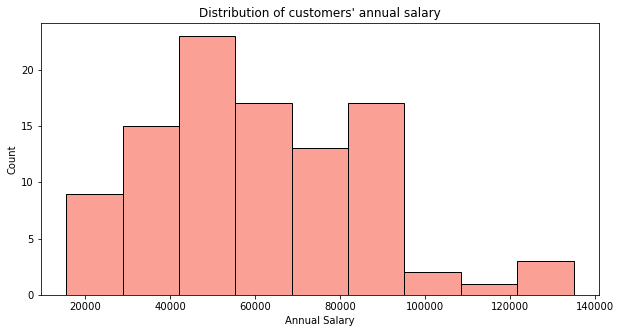

In [11]:
plt.figure(figsize=(10,5))
sns.histplot(salary_df.annual_salary,color='salmon')
plt.title("Distribution of customers' annual salary")
plt.xlabel('Annual Salary')

## Investigating Predictor variables


In [12]:
# Amount of customers within the given dataset
unique_id = data.customer_id.unique()
len(unique_id)

100

In [13]:
# Average number of transactions every week
avg_no_weekly_trans = []

for id_ in unique_id:
    array = data.loc[data.customer_id == id_,'date']
    avg_no_weekly_trans.append(round(len(array)/array.nunique()*7))

In [14]:
# Number of days with transactions
no_days_with_trans = []

for id_ in unique_id:
    array= data.loc[data.customer_id == id_,'date']
    no_days_with_trans.append(array.nunique())

In [15]:
# Number of large transactions (define as larger than 150$)
no_large_trans = []

for id_ in unique_id:
    count= 0 
    array = data.loc[data.customer_id ==id_,'amount']
    
    for amount in array:
        if amount > 150:
            count+=1
    no_large_trans.append(count)

In [16]:
# Maximum amount
max_amount=[]

for id_ in unique_id:
    array = data.loc[data.customer_id == id_,'amount']
    max_amount.append(max(array))

In [17]:
# Average transaction amount
avg_trans_amount = []

for id_ in unique_id:
    array = data.loc[data.customer_id==id_,'amount']
    avg_trans_amount.append(array.mean())

In [18]:
#Median balance
median_bal = []

for id_ in unique_id:
    array = data.loc[data.customer_id==id_,'balance']
    median_bal.append(array.median())

In [19]:
# State of residence
state = []

for id_ in unique_id:
    array= data.loc[data.customer_id == id_,'merchant_state']
    state.append(mode(array))

In [20]:
# Adding 'age' and 'gender' from the original dataset
age =[]

for id_ in unique_id:
    array = data.loc[data.customer_id==id_,'age']
    age.append(mode(array))

In [21]:
gender = []
for id_ in unique_id:
    array= data.loc[data.customer_id==id_,'gender']
    gender.append(mode(array))

In [36]:
# Predictor variables

df1 = pd.DataFrame({"customer_id": unique_id,
                            "no_days_with_trans":no_days_with_trans,
                            "avg_no_weekly_trans": avg_no_weekly_trans, 
                            "max_amount": max_amount, 
                            "no_large_trans": no_large_trans,
                            "avg_trans_amount": avg_trans_amount,
                            "median_balance": median_bal, 
                            "state": state,
                            "age": age,
                            "gender": gender})
df1.head()

,customer_id,no_days_with_trans,avg_no_weekly_trans,max_amount,no_large_trans,avg_trans_amount,median_balance,state,age,gender
0,CUS-2487424745,85,48,1452.21,22,45.423508,1580.40,QLD,26,F
1,CUS-2142601169,74,29,2349.55,19,78.225546,1132.66,NSW,38,M
2,CUS-1614226872,76,24,892.09,17,74.470483,3618.50,QLD,40,F
3,CUS-2688605418,63,14,2320.30,17,159.304186,5616.63,NSW,20,M
4,CUS-4123612273,44,21,1068.04,27,166.508358,6162.45,VIC,43,F


In [37]:
# Target variable
salary_df.head()

,customer_id,salary_freq,salary_amount,annual_salary
0,CUS-2487424745,7,1013.67,52855.650000
1,CUS-2142601169,7,1002.13,52253.921429
2,CUS-1614226872,7,892.09,46516.121429
3,CUS-2688605418,14,2320.30,60493.535714
4,CUS-4123612273,7,1068.04,55690.657143


In [38]:
#Concatenate annual salary column to the feature dataframe

df= pd.concat([df1,salary_df.annual_salary],axis=1)
df.head()

,customer_id,no_days_with_trans,avg_no_weekly_trans,max_amount,no_large_trans,avg_trans_amount,median_balance,state,age,gender,annual_salary
0,CUS-2487424745,85,48,1452.21,22,45.423508,1580.40,QLD,26,F,52855.650000
1,CUS-2142601169,74,29,2349.55,19,78.225546,1132.66,NSW,38,M,52253.921429
2,CUS-1614226872,76,24,892.09,17,74.470483,3618.50,QLD,40,F,46516.121429
3,CUS-2688605418,63,14,2320.30,17,159.304186,5616.63,NSW,20,M,60493.535714
4,CUS-4123612273,44,21,1068.04,27,166.508358,6162.45,VIC,43,F,55690.657143


In [39]:
# Get information for the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   customer_id          100 non-null    object 
 1   no_days_with_trans   100 non-null    int64  
 2   avg_no_weekly_trans  100 non-null    int64  
 3   max_amount           100 non-null    float64
 4   no_large_trans       100 non-null    int64  
 5   avg_trans_amount     100 non-null    float64
 6   median_balance       100 non-null    float64
 7   state                100 non-null    object 
 8   age                  100 non-null    int64  
 9   gender               100 non-null    object 
 10  annual_salary        100 non-null    float64
dtypes: float64(4), int64(4), object(3)
memory usage: 8.7+ KB


## Correlation between the features and salary 

C:\Users\zipzi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='age', ylabel='annual_salary'>

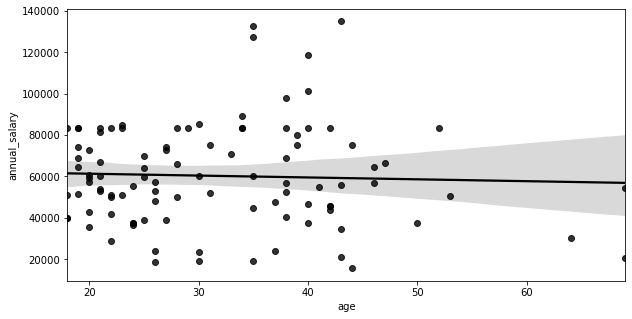

In [40]:
# Observing correlation between customer age and salary

plt.figure(figsize=(10,5))
sns.regplot('age','annual_salary',data=df,color='black')

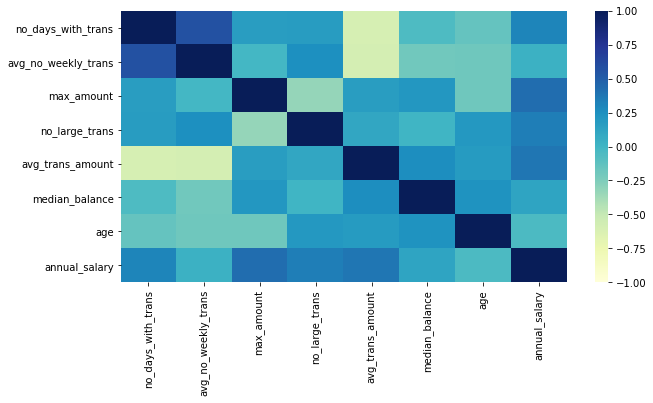

In [41]:
fig, ax = plt.subplots(figsize=(10,5)) 
sns.heatmap(df.corr(), annot=False, cmap='YlGnBu', vmin=-1, vmax=1, center=0, ax=ax)
plt.show()

# Preprocessing for our prediction

In [42]:
# import libraries for machine learning

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

## Train test split

In [43]:
X = df.drop(['customer_id'],axis=1)
Y= df.annual_salary
print('X shape: ', X.shape)
print('Y shape: ', Y.shape)

X shape:  (100, 10)
Y shape:  (100,)


In [44]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

print("X_train shape: ", X_train.shape)
print("Y_train shape: ", Y_train.shape)
print("X_test shape: ", X_test.shape)
print("Y_test shape: ", Y_test.shape)

X_train shape:  (80, 10)
Y_train shape:  (80,)
X_test shape:  (20, 10)
Y_test shape:  (20,)


## Column transformer with one hot encoder and standard scaler

In [45]:
df.columns

Index(['customer_id', 'no_days_with_trans', 'avg_no_weekly_trans',
       'max_amount', 'no_large_trans', 'avg_trans_amount', 'median_balance',
       'state', 'age', 'gender', 'annual_salary'],
      dtype='object')

In [46]:
ohe = OneHotEncoder(sparse = False)
scaler = StandardScaler()
column_transform = make_column_transformer((ohe, ["state", "gender"]),
                                           (scaler, ["avg_no_weekly_trans","no_days_with_trans", "max_amount",
                                                     "no_large_trans", "avg_trans_amount", 
                                                     "median_balance", "age"]))
column_transform = make_column_transformer((ohe, ["state", "gender"]), (scaler, ["avg_no_weekly_trans", "max_amount", "no_large_trans", "avg_trans_amount", "median_balance", "age"]))                                           


# Predict Customers' annual salary

## Linear Regression

In [47]:
lm = LinearRegression()
lm_pipeline = make_pipeline(column_transform, lm)

In [48]:
lm_pipeline.fit(X_train, Y_train)
lm_pred = lm_pipeline.predict(X_test)

In [49]:
print("RMSE: ", round(np.sqrt(mean_squared_error(lm_pred, Y_test))))

RMSE:  22944


## Decision tree

In [50]:
tree = DecisionTreeRegressor()
tree_pipeline = make_pipeline(column_transform, tree)

In [51]:
tree_pipeline.fit(X_train, Y_train)
tree_pred = tree_pipeline.predict(X_test)

In [52]:
print("RMSE: ", round(np.sqrt(mean_squared_error(tree_pred, Y_test))))

RMSE:  24092


In [55]:
column_transform

ColumnTransformer(transformers=[('onehotencoder', OneHotEncoder(sparse=False),
                                 ['state', 'gender']),
                                ('standardscaler', StandardScaler(),
                                 ['avg_no_weekly_trans', 'max_amount',
                                  'no_large_trans', 'avg_trans_amount',
                                  'median_balance', 'age'])])

## Random Forest 

In [58]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)
forest_pipeline = make_pipeline(column_transform, forest_reg)

In [59]:
forest_pipeline.fit(X_train, Y_train)
forest_pred = forest_pipeline.predict(X_test)

In [60]:
print("RMSE: ", round(np.sqrt(mean_squared_error(forest_pred, Y_test))))

RMSE:  19162
